In [1]:
from fb_viz.dashboards.defensive_dashboard import DefensiveDashboard
from dbconnect.connector import mysql_engine
from fb_viz.helpers.mclachbot_helpers import get_image_remote, sportsdb_image_grabber
%matplotlib inline


In [2]:
sportsdb_image_grabber('real_valladolid','la liga')

In [3]:
engine = mysql_engine('M0neyMa$e')

In [4]:
dd = DefensiveDashboard(engine, sportsdb_image_grabber)

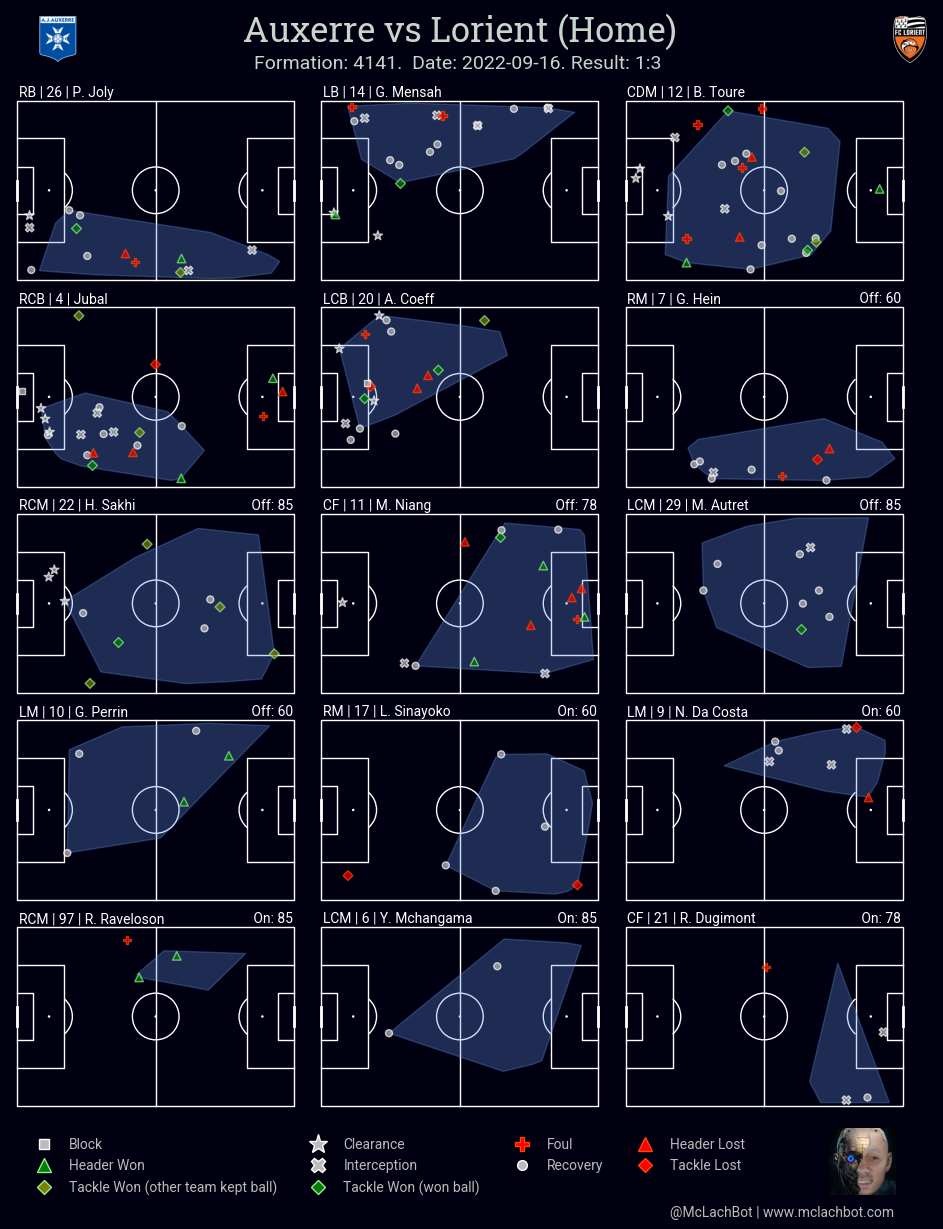

In [5]:
grid_params = {
    'title_height':0.06,
    'figheight':12,
    'grid_height':0.85,
    'endnote_height':0.06
}
fig,_ = dd.plot(dd.get_data('auxerre', '2022-09-16'))
fig

In [271]:
from footmav.data_definitions.whoscored.constants import EventType, PassType
from tabulate import tabulate

def _change_name(name):
    tokens = name.split(' ')
    if len(tokens) == 1:
        return name.title()
    else:
        return ' '.join([' '.join([f'{t[0].upper()}.' for t in tokens[:1]]), tokens[-1].title()]) 
def lineup_card(data):
    
    lineup_card=data[['shirt_number','player_name','position']].groupby(['shirt_number']).first().reset_index()
    lineup_card=lineup_card.loc[lineup_card['shirt_number']!=-1]
    subs = data.loc[data['event_type']==EventType.SubstitutionOn][['player_name','minute','second']].set_index('player_name').to_dict()['minute']
    subs_off = data.loc[data['event_type']==EventType.SubstitutionOff][['player_name','minute','second']].set_index('player_name').to_dict()['minute']
    lineup_card['on'] = lineup_card['player_name'].map(subs).fillna(0).astype(int)
    lineup_card['is_position']=lineup_card['position'].apply(lambda x: 1 if x != 'GK' else 0)
    lineup_card['off'] = lineup_card['player_name'].map(subs_off).fillna(0).astype(int).astype(str)
    lineup_card['off'] = lineup_card['off'].apply(lambda x: x if x!='0' else '--')
    lineup_card['player_name']=lineup_card['player_name'].apply(_change_name)
    lineup_card=lineup_card.sort_values(['is_position','on','shirt_number'])
    lineup_card = lineup_card.rename(columns={'player_name':'Player','position':'Pos','shirt_number':'No.','on':'On','off':'Off'})
    starters = lineup_card.loc[lineup_card['On']==0]
    subs = lineup_card.loc[lineup_card['On']!=0]
    subs = subs.sort_values('On')
    subs['On']=subs['On'].astype(str)

    return (
        tabulate(starters[['Pos','Player','No.','Off']], headers='keys', showindex=False, tablefmt='pretty'), 
        tabulate(subs[['Pos','Player','No.','On']], headers='keys', showindex=False, tablefmt='pretty')
    )

In [495]:
from fb_viz.dashboards.dashboard import Dashboard, WithFormationDataMixin
from fb_viz.helpers.pitch_helpers import (
plot_average_position_on_pitch_by_position_for_starting_formation, plot_pass_network_on_pitch_by_position_for_starting_formation,
plot_average_position_on_pitch_by_player_for_starters, plot_pass_network_on_pitch_by_player_for_starters
)
from fb_viz.helpers.fonts import font_normal
from mplsoccer.pitch import Pitch
class PassNetworkDashboard(WithFormationDataMixin, Dashboard):
    DATA_QUERY = """
        SELECT W.*, L.formation, L.position, L.shirt_number, L.pass_receiver, L.pass_receiver_position, L.pass_receiver_shirt_number, P.passtypes,
        IF(W.is_home_team=True, M.home_score, M.away_score) AS team_score,
        IF(W.is_home_team=True, M.away_score, M.home_score) AS opponent_score

        FROM football_data.whoscored W
        JOIN derived.whoscored_extra_event_info L
        ON W.id = L.id
        JOIN derived.whoscored_pass_types P 
        ON W.id = P.id
        JOIN whoscored_meta M 
        ON W.matchId = M.matchId
        WHERE W.matchId = {} AND W.team = '{}'
        """
    
    GRID_PARAMETERS=dict(
        left=0.15,
        grid_width=0.85,
        figheight=10,
        title_height=0.05,
        endnote_space=0,
        title_space = 0,
        grid_height=0.85,
        endnote_height=0.02
    )
    WATERMARK_DICT = dict(
        s="@McLachBot | www.mclachbot.com",
        x=0.01,
        y=3.5,
        ha="left",
        va="top",
    )
    HOME_IMAGE_COORDS = (0.18, 0.9, 0.07)
    AWAY_IMAGE_COORDS = (0.9, 0.9, 0.07)
    MCLACHEAD_COORDS = (0.17, 0.13, 0.07, 0.07)
    PASS_MININUM = 3

    def populate_sidepanel(self, data, ax, pitch_color, text_color):
        data=data.copy()
        ax.set_facecolor(pitch_color)
        ax.axis('off')
        result_sets={}
        result_sets['Passes Attempted'] = data.loc[data['event_type']==EventType.Pass].groupby(['shirt_number','player_name']).agg({'x':'count'}).reset_index().rename(columns={'x':'passes_attempted'}).sort_values('passes_attempted', ascending=False)
        result_sets['Passes Completed'] = data.loc[data['event_type']==EventType.Pass].groupby(['shirt_number','player_name']).agg({'outcomeType':'sum'}).reset_index().rename(columns={'outcomeType':'passes_completed'}).sort_values('passes_completed', ascending=False)
        pct_passes_completed = result_sets['Passes Completed'] .merge(result_sets['Passes Attempted'], on=['shirt_number','player_name'])
        pct_passes_completed['pct_passes_completed'] = pct_passes_completed['passes_completed']/pct_passes_completed['passes_attempted']
        pct_passes_completed = pct_passes_completed.loc[pct_passes_completed['passes_attempted']>20]
        pct_passes_completed = pct_passes_completed.sort_values('pct_passes_completed', ascending=False)
        pct_passes_completed=pct_passes_completed[['shirt_number','player_name','pct_passes_completed']]
        pct_passes_completed['pct_passes_completed']=pct_passes_completed['pct_passes_completed'].apply(lambda x: f'{x*100:.0f}%')
        result_sets['Pct Passes Completed'] = pct_passes_completed
        data['progressive']=data['passtypes'].apply(lambda x: x & (1<<(PassType.PROGRESSIVE.value-1))>0)
        progressive_passes_attempted = data.loc[data['event_type']==EventType.Pass].groupby(['shirt_number','player_name']).agg({'progressive':'sum'}).reset_index().rename(columns={'progressive':'progressive_passes_attempted'}).sort_values('progressive_passes_attempted', ascending=False)
        result_sets['Prog. Passes Attempted'] = progressive_passes_attempted
        progressive_passes_completed = data.loc[(data['event_type']==EventType.Pass)&(data['progressive'])].groupby(['shirt_number','player_name']).agg({'outcomeType':'sum'}).reset_index().rename(columns={'outcomeType':'progressive_passes_completed'}).sort_values('progressive_passes_completed', ascending=False)
        result_sets['Prog. Passes Completed'] = progressive_passes_completed
        progressive_passes_received = data.loc[(data['event_type']==EventType.Pass)&(data['progressive'])].groupby(['pass_receiver_shirt_number','pass_receiver']).agg({'x':'count'}).reset_index().rename(columns={'x':'progressive_passes_received','pass_receiver':'player_name', 'pass_receiver_shirt_number':'shirt_number'}).sort_values('progressive_passes_received', ascending=False)
        progressive_passes_received['shirt_number']=progressive_passes_received['shirt_number'].astype(int)
        result_sets['Prog. Passes Received'] = progressive_passes_received
        for i, (k,v) in enumerate(result_sets.items()):
            v['player_name']=v['player_name'].apply(_change_name)
            txt = f"\n{k}"
            txt += "\n--------------------------"
            
            for j, row in v[0:3].iterrows():
                txt += f"\n{row.values[0]:<3}{row.values[1]:<20}{row.values[2]:<3}"
            txt += "\n"
            #xt = tabulate(v[:3], tablefmt='plain', stralign='left',numalign='left')
            


       
            ax.text(0.02, 1.13-i*0.12, txt, family='monospace', transform=ax.transAxes, va='top', ha='left', color=text_color)

    def _dashboard_plot_impl(self, fig, axes, pitch:Pitch, data, pitch_color, line_color, marker_base_color):
        
        plot_average_position_on_pitch_by_position_for_starting_formation(axes['pitch'], pitch, data)
        plot_pass_network_on_pitch_by_position_for_starting_formation(axes['pitch'], pitch, data, min_combinations=self.PASS_MININUM)
        axes['sidepanel']=fig.add_axes([0.0, 0.05, 0.15, 0.82])
        self.populate_sidepanel(data, axes['sidepanel'], pitch_color, line_color)

        starters, subs = lineup_card(data)
        starters_count_width = starters.find('\n')
        starters_title_formatter = r'{:^' + str(starters_count_width) + '}\n'+'-'*starters_count_width+'\n'
        axes['sidepanel'].text(
            transform=axes['sidepanel'].transAxes,
            color=line_color,
            family='monospace',
            fontsize=8,
            #s=starters_title_formatter.format("Starters")+starters,
            s=starters,
            x = 0.02, 
            y = 0.4,
            ha='left',
            va='top',
        )
        axes['sidepanel'].text(
            transform=axes['sidepanel'].transAxes,
            color=line_color,
            family='monospace',
            fontsize=8,
            #s=starters_title_formatter.format("Starters")+starters,
            s=subs,
            x = 0.02, 
            y = 0.17,
            ha='left',
            va='top',
        )
        axes['endnote'].text(
            transform=axes['endnote'].transAxes,
            color=line_color,
            fontproperties=font_normal.prop,
            fontsize=10,
            s=f"Red lines are progressive passes made between players.\n Minimum of {"
        )
        return fig, axes

    

In [496]:
dd=PassNetworkDashboard(engine, sportsdb_image_grabber)

In [497]:
data = dd.get_data('barcelona', '2022-09-17')
fig, axes = dd.plot(data)

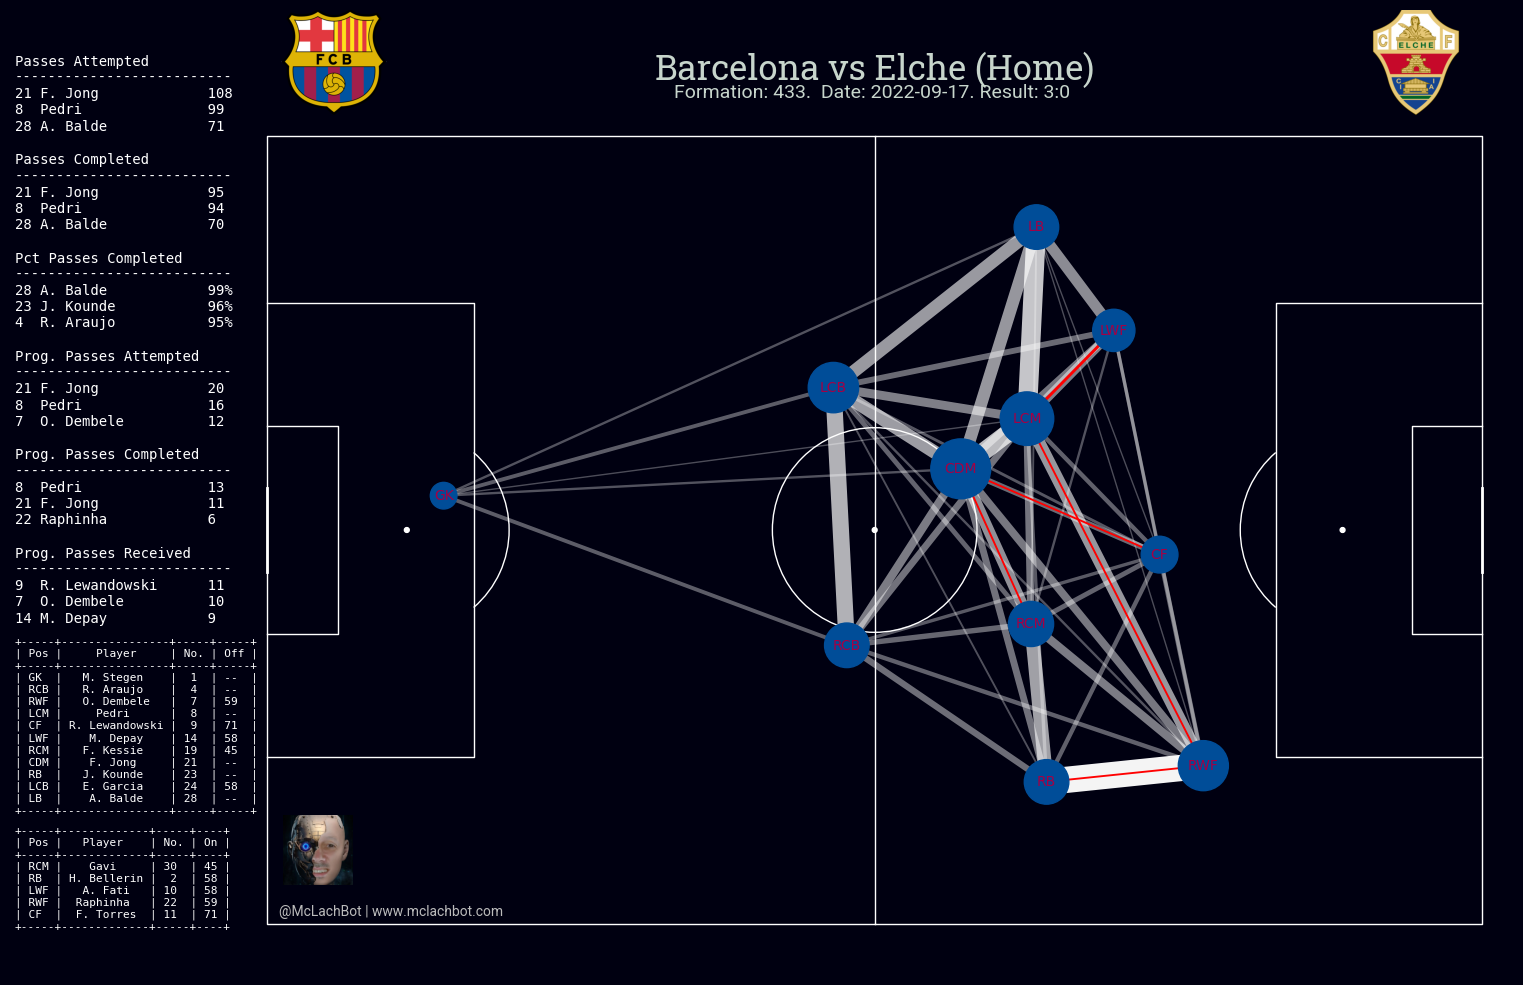

In [498]:
fig

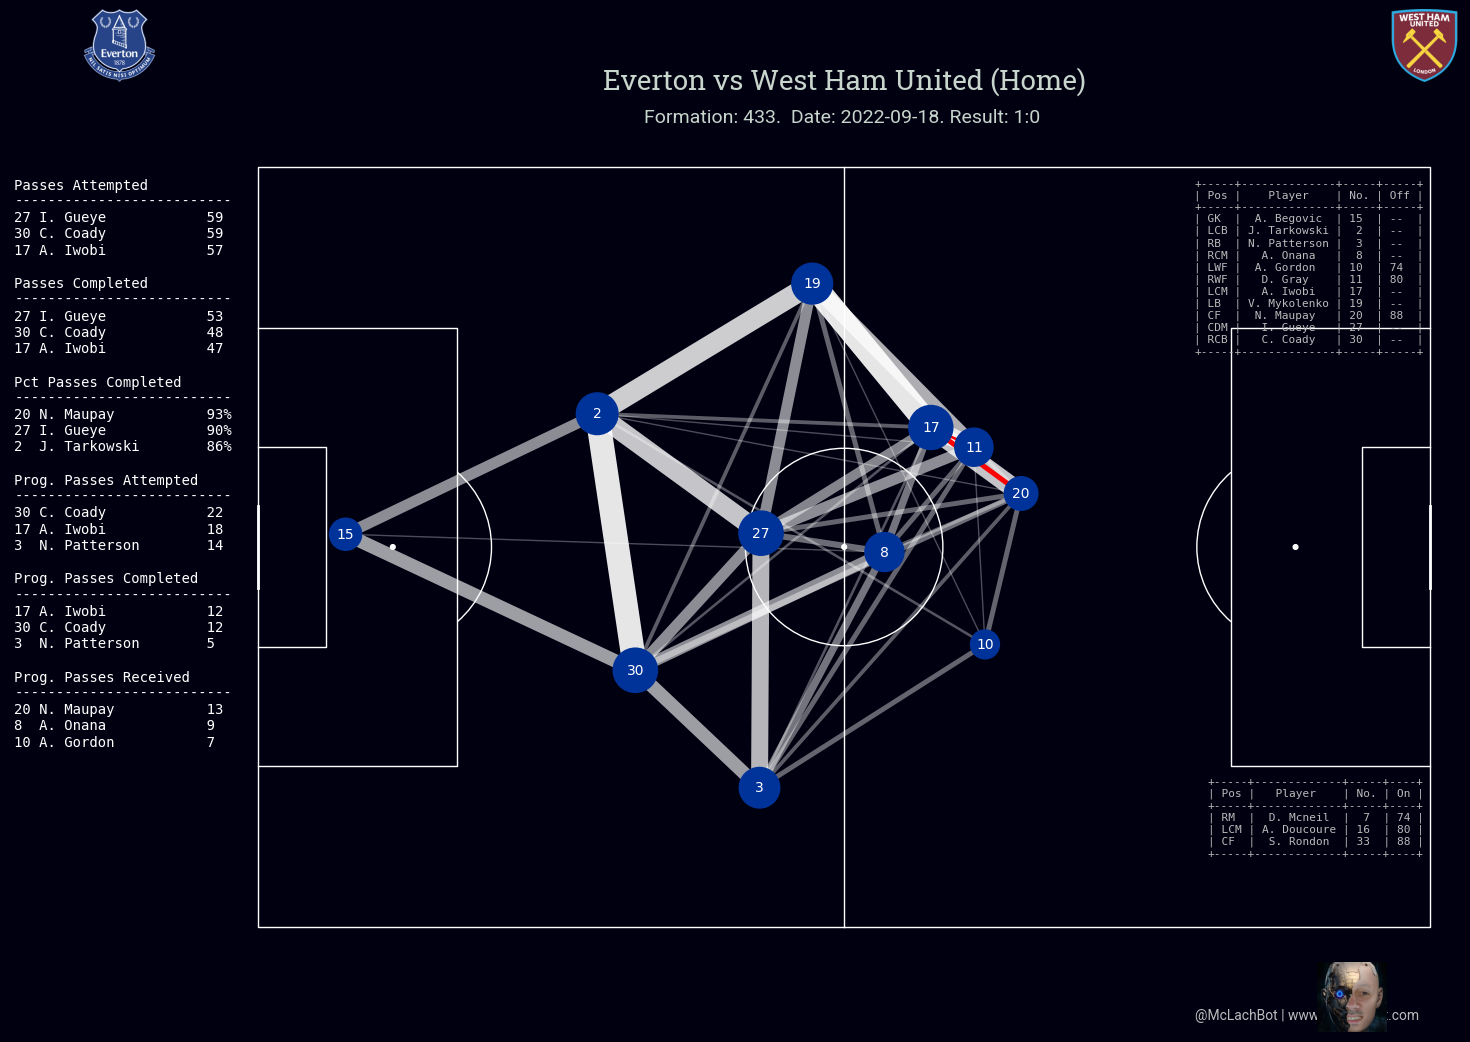

In [379]:
fig

In [62]:
data.sort_values(['period','minute','second'])

,id,meta_id,globalId,eventId,minute,second,teamId,x,y,expandedMinute,...,position,shirt_number,pass_receiver,pass_receiver_position,passtypes,team_score,opponent_score,formation_id,formation_name,team_player_formation
466,2151272485,2640,2461925627,4,0,9,31,13.5,30.0,0,...,RCB,30,None,None,2,1,0,4.0,433,5.0
467,2151272484,2640,2461925565,3,0,9,31,13.1,29.1,0,...,RCB,30,None,None,0,1,0,4.0,433,5.0
465,2151272489,2640,2461925799,5,0,17,31,26.6,41.5,0,...,LCB,2,None,None,0,1,0,4.0,433,6.0
464,2151272490,2640,2461926067,6,0,27,31,27.3,38.9,0,...,RCB,30,james tarkowski,LCB,0,1,0,4.0,433,5.0
463,2151272491,2640,2461926105,7,0,28,31,24.4,67.9,0,...,LCB,2,conor coady,RCB,0,1,0,4.0,433,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,2151273959,2640,2462045791,868,95,20,31,71.5,58.8,97,...,CF,33,None,None,0,1,0,7.0,4141,9.0
471,2151273960,2640,2462045799,869,95,22,31,70.7,48.4,97,...,CF,33,alexander iwobi,LM,0,1,0,7.0,4141,9.0
470,2151273961,2640,2462045821,870,95,23,31,68.3,28.8,97,...,LM,17,abdoulaye doucoure,LCM,2,1,0,7.0,4141,11.0
469,2151273962,2640,2462045939,871,95,24,31,81.3,48.2,97,...,LCM,16,alexander iwobi,LM,0,1,0,7.0,4141,10.0


In [63]:
fig, ax, pitch = dd.plot(data)

In [64]:
from footmav.data_definitions.whoscored.constants import EventType
from fb_viz.definitions.events import get_attacking_touch_events, get_touch_events
from fb_viz.helpers.mclachbot_helpers import team_colours
from footmav.data_definitions.whoscored.constants import PassType
import pandas as pd
import numpy as np
from matplotlib.colors import to_rgba

def get_starter_locations(data, label_column):
    subs = data.loc[data['event_type']==EventType.SubstitutionOn,'player_name']
    
    starter_actions = get_touch_events(data.loc[~data['player_name'].isin(subs)])
    by_player = starter_actions.groupby(list(set(['player_name',label_column]))).agg({'x':['count','mean'],'y':['mean']})
    by_player.columns = ['count','x','y']
    by_player = by_player.reset_index()
    return by_player

def get_locations_by_starting_formation(data, label_column):
    
    
    actions = get_touch_events(data.loc[data['formation']==data['formation'].iloc[0]])
    py_position = actions.groupby(list(set(['position',label_column]))).agg({'x':['count','mean'],'y':['mean']})
    py_position.columns = ['count','x','y']
    py_position = py_position.reset_index()
    return py_position

def plot_average_position_on_pitch_by_player_for_starters(ax, pitch, data, min_size = 15, max_size=40, max_count=120):
    label_column = 'shirt_number'
    team = data['team'].iloc[0]
    league= data['competition'].iloc[0]
    by_player = get_starter_locations(data, label_column)
    by_player['s']=min_size + by_player['count']/max_count *(max_size-min_size)
    colours = team_colours(team, league)
    pitch.scatter(by_player['x'],by_player['y'],s=by_player['s']**2,ax=ax, zorder=4, c=colours[0])
    for i, row in by_player.iterrows():
        pitch.annotate(row[label_column], xy=(row.x,row.y), va='center',ha='center', zorder=5, ax=ax, c=colours[1])

def plot_average_position_on_pitch_by_position_for_starting_formation(ax, pitch, data, min_size = 15, max_size=40, max_count=120):
    label_column = 'position'
    team = data['team'].iloc[0]
    league= data['competition'].iloc[0]
    by_player = get_locations_by_starting_formation(data, label_column)
    by_player['s']=min_size + by_player['count']/max_count *(max_size-min_size)
    colours = team_colours(team, league)
    pitch.scatter(by_player['x'],by_player['y'],s=by_player['s']**2,ax=ax, zorder=4, c=colours[0])
    for i, row in by_player.iterrows():
        pitch.annotate(row[label_column], xy=(row.x,row.y), va='center',ha='center', zorder=5, ax=ax, c=colours[1])



def get_starter_pass_network_by_name(data, min_combinations):
    subs = data.loc[data['event_type']==EventType.SubstitutionOn,'player_name']
    
    player_passes =  data.loc[
        (data['event_type']==EventType.Pass)&
        (data['outcomeType']==1)&
        (~data['player_name'].isin(subs))&
        (~data['pass_receiver'].isin(subs))&
        (data['pass_receiver'].notnull())
        ].copy()
    player_passes['pair']=player_passes.apply(lambda r: '_'.join(sorted([r['player_name'],r['pass_receiver'] if r['pass_receiver'] else ''])), axis=1)
    
    player_passes['progressive_pass']=player_passes['passtypes'].apply(lambda x: x & (1<<(PassType.PROGRESSIVE.value-1))>0)
    pass_groupings = player_passes.groupby('pair').agg({'x':'count','player_name':'first','pass_receiver':'first','progressive_pass':'sum'})
    pass_groupings=pass_groupings[pass_groupings['pass_receiver'].notnull()]
    pass_groupings.columns = ['count','player','receiver', 'progressive_count']
    pass_groupings = pass_groupings.loc[pass_groupings['count']>=min_combinations]
    return pass_groupings

def get_starter_pass_network_by_position(data, min_combinations):
    subs = data.loc[data['event_type']==EventType.SubstitutionOn,'player_name']
    
    player_passes =  data.loc[
        (data['event_type']==EventType.Pass)&
        (data['outcomeType']==1)&
        (data['formation']==data['formation'].iloc[0])&
        (data['pass_receiver'].notnull())
        ].copy()
    player_passes['pair']=player_passes.apply(lambda r: '_'.join(sorted([r['position'],r['pass_receiver_position'] if r['pass_receiver_position'] else ''])), axis=1)
    
    player_passes['progressive_pass']=player_passes['passtypes'].apply(lambda x: x & (1<<(PassType.PROGRESSIVE.value-1))>0)
    pass_groupings = player_passes.groupby('pair').agg({'x':'count','position':'first','pass_receiver_position':'first','progressive_pass':'sum'})
    pass_groupings=pass_groupings[pass_groupings['pass_receiver_position'].notnull()]
    pass_groupings.columns = ['count','player','receiver', 'progressive_count']
    pass_groupings = pass_groupings.loc[pass_groupings['count']>=min_combinations]
    return pass_groupings

def plot_pass_network_on_pitch_by_player_for_starters(ax, pitch, data, max_combinations=20, min_width=1, max_width=20, min_transparency=0.3, min_combinations=3):
    pass_groupings = get_starter_pass_network_by_name(data, min_combinations)
    average_positions = get_starter_locations(data, 'shirt_number')
    pass_groupings = pd.merge(
        pass_groupings,
        average_positions[['player_name','x','y']],
        left_on='player',
        right_on='player_name',
        how='left'
    ).rename(columns={'x':'start_x','y':'start_y'})
    pass_groupings = pd.merge(
        pass_groupings,
        average_positions[['player_name','x','y']],
        left_on='receiver',
        right_on='player_name',
        how='left'
    ).rename(columns={'x':'end_x','y':'end_y'})

    total_max = max(pass_groupings['count'].max(), max_combinations)
    pass_groupings['width']=min_width + (pass_groupings['count']-min_combinations)/total_max *(max_width-min_width)
    pass_groupings['pp_width']=min_width + (pass_groupings['progressive_count']-min_combinations)/total_max *(max_width-min_width)
    
    pass_groupings_pp = pass_groupings.loc[pass_groupings['progressive_count']>min_combinations]
    color = np.array(to_rgba('white'))
    color= np.tile(color, (len(pass_groupings),1))
    c_transparency = min_transparency + (pass_groupings['count']-min_combinations)/total_max *(1-min_transparency)
    color[:,3]=c_transparency
    pitch.lines(
        pass_groupings['start_x'],
        pass_groupings['start_y'],
        pass_groupings['end_x'],
        pass_groupings['end_y'],
        ax=ax,
        color=color,
        lw=pass_groupings['width'],
        zorder=2,
        
    )
    pitch.lines(
        pass_groupings_pp['start_x'],
        pass_groupings_pp['start_y'],
        pass_groupings_pp['end_x'],
        pass_groupings_pp['end_y'],
        ax=ax,
        color="red",
        lw=pass_groupings_pp['pp_width'],
        zorder=3,
        
    )
    return pass_groupings


def plot_pass_network_on_pitch_by_position_for_starting_formation(ax, pitch, data, max_combinations=20, min_width=1, max_width=20, min_transparency=0.3, min_combinations=3):
    pass_groupings = get_starter_pass_network_by_position(data, min_combinations)
    average_positions = get_locations_by_starting_formation(data, 'position')
    print(average_positions)
    print(pass_groupings)
    pass_groupings = pd.merge(
        pass_groupings,
        average_positions[['position','x','y']],
        left_on='player',
        right_on='position',
        how='left'
    ).rename(columns={'x':'start_x','y':'start_y'})
    pass_groupings = pd.merge(
        pass_groupings,
        average_positions[['position','x','y']],
        left_on='receiver',
        right_on='position',
        how='left'
    ).rename(columns={'x':'end_x','y':'end_y'})

    total_max = max(pass_groupings['count'].max(), max_combinations)
    pass_groupings['width']=min_width + (pass_groupings['count']-min_combinations)/total_max *(max_width-min_width)
    pass_groupings['pp_width']=min_width + (pass_groupings['progressive_count']-min_combinations)/total_max *(max_width-min_width)
    
    pass_groupings_pp = pass_groupings.loc[pass_groupings['progressive_count']>min_combinations]
    color = np.array(to_rgba('white'))
    color= np.tile(color, (len(pass_groupings),1))
    c_transparency = min_transparency + (pass_groupings['count']-min_combinations)/total_max *(1-min_transparency)
    color[:,3]=c_transparency
    pitch.lines(
        pass_groupings['start_x'],
        pass_groupings['start_y'],
        pass_groupings['end_x'],
        pass_groupings['end_y'],
        ax=ax,
        color=color,
        lw=pass_groupings['width'],
        zorder=2,
        
    )
    pitch.lines(
        pass_groupings_pp['start_x'],
        pass_groupings_pp['start_y'],
        pass_groupings_pp['end_x'],
        pass_groupings_pp['end_y'],
        ax=ax,
        color="red",
        lw=pass_groupings_pp['pp_width'],
        zorder=3,
        
    )
    return pass_groupings



    

   position  count          x          y
0       CDM     70  42.851429  50.711429
1        CF     38  63.926316  54.818421
2        GK     32   7.443750  52.146875
3        LB     57  45.564912  83.592982
4       LCB     62  29.022581  67.085484
5       LCM     65  51.849231  62.723077
6       LWF     31  60.529032  34.793548
7        RB     59  44.854237  18.476271
8       RCB     77  32.314286  33.759740
9       RCM     50  49.230000  40.660000
10      RWF     60  61.066667  63.145000
         count player receiver  progressive_count
pair                                             
CDM_CF       4    CDM       CF                  0
CDM_LB       8     LB      CDM                  0
CDM_LCB     15    LCB      CDM                  0
CDM_LCM     10    CDM      LCM                  1
CDM_RB      15     RB      CDM                  0
CDM_RCB     11    CDM      RCB                  2
CDM_RCM      6    CDM      RCM                  0
CDM_RWF     11    RWF      CDM                  0
CF_LCB  

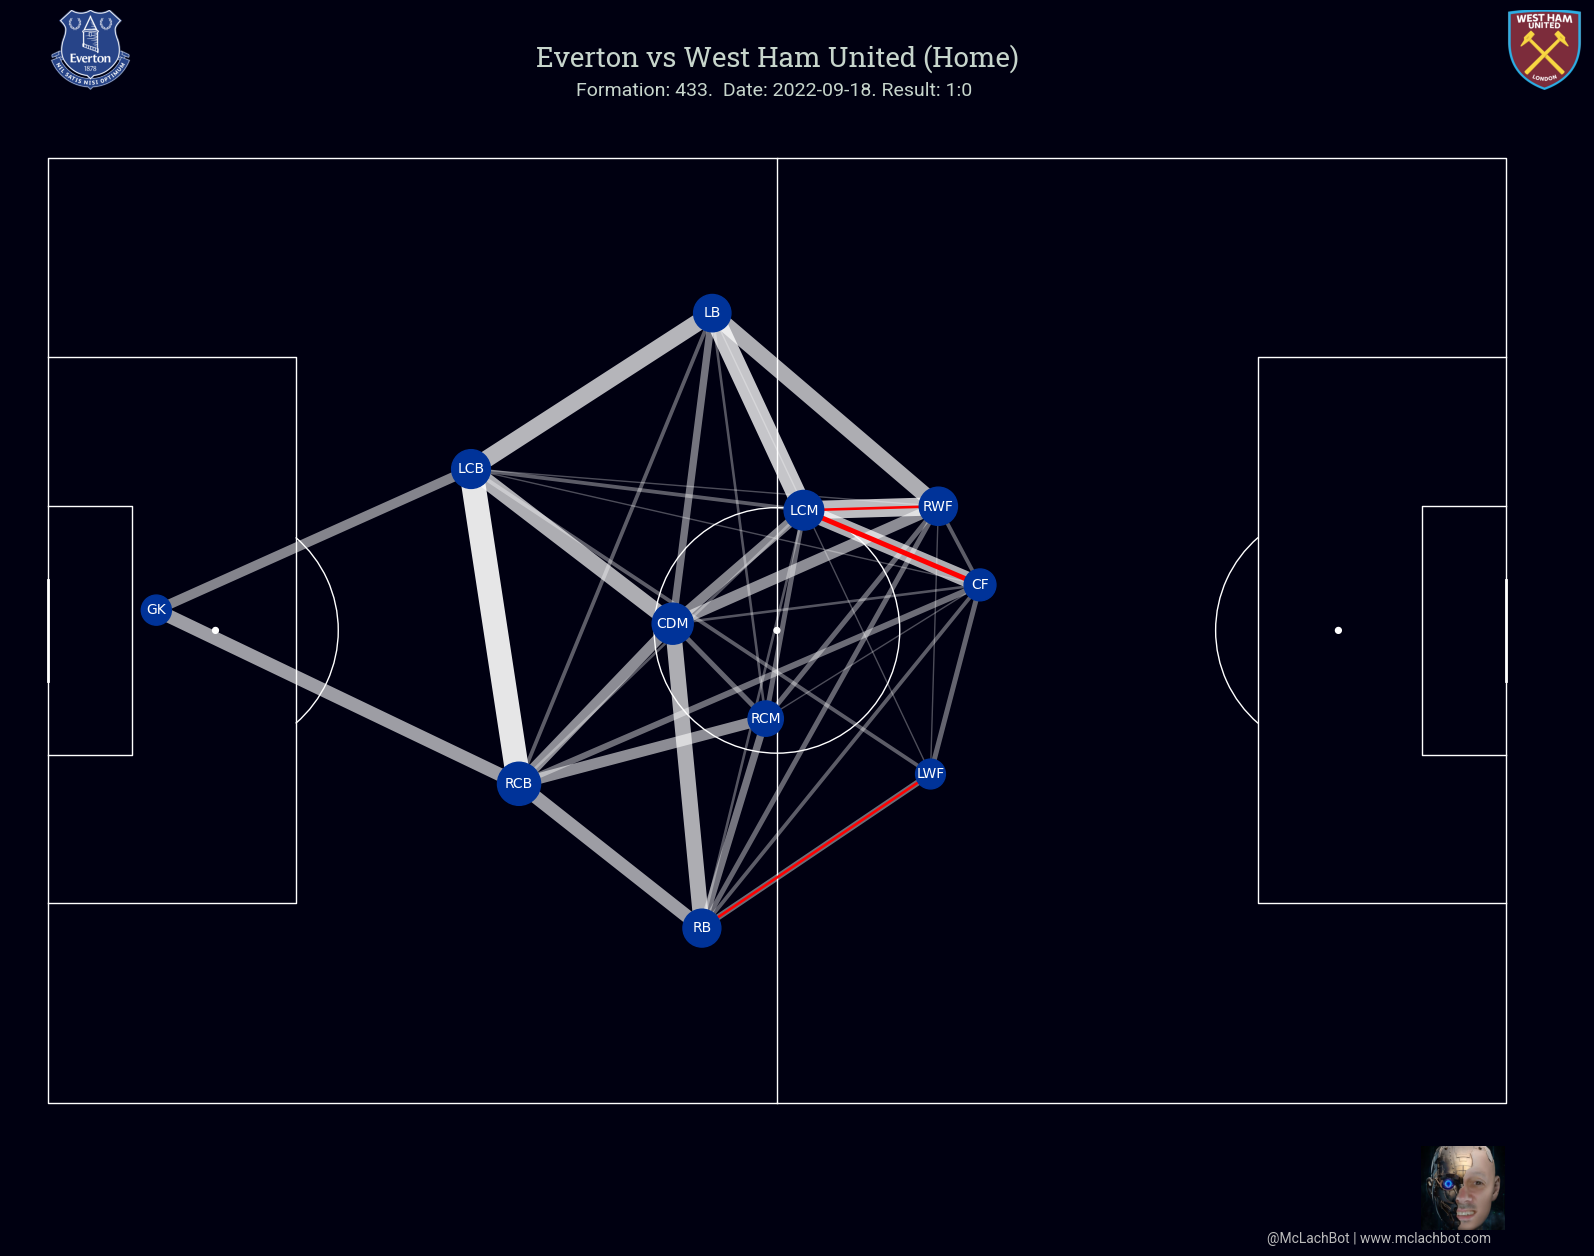

In [65]:
fig

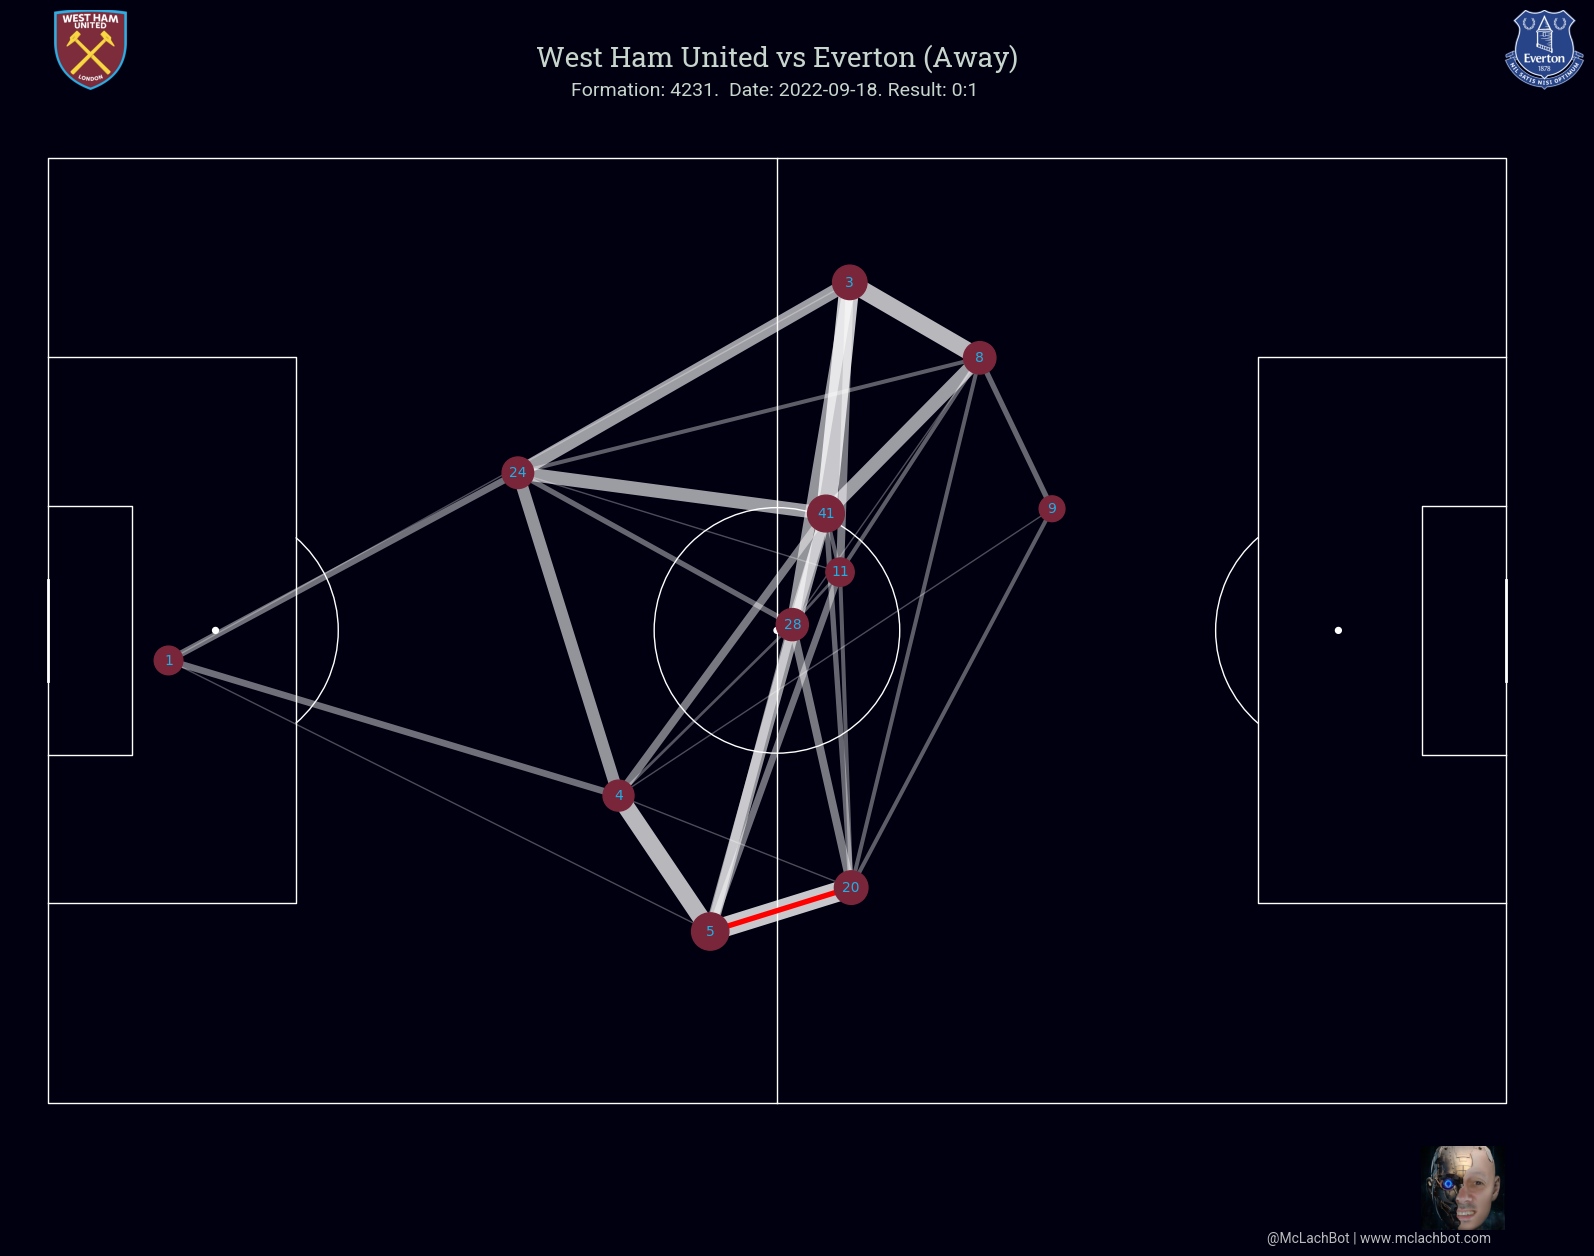

In [12]:
fig

In [91]:
from footmav.data_definitions.whoscored.constants import PassType
data['progressive_pass']=data['passtypes'].apply(lambda x: x & (1<<(PassType.PROGRESSIVE.value-1))>0)

In [107]:
data.loc[(data['pass_receiver']=='vladimir coufal')&(data['player_name']=='lukasz fabianski')][['event_type','outcomeType','x','y','endX','endY','passtypes','progressive_pass']]

,event_type,outcomeType,x,y,endX,endY,passtypes,progressive_pass
414,EventType.Pass,1,4.7,53.6,50.9,2.8,2,True


In [98]:
data.loc[(data['pass_receiver']=='thilo kehrer')&(data['player_name']=='kurt zouma')][['event_type','outcomeType','x','y','endX','endY','passtypes','progressive_pass']]

,event_type,outcomeType,x,y,endX,endY,passtypes,progressive_pass
52,EventType.Pass,1,46.5,0.0,45.9,27.5,0,False
130,EventType.Pass,1,32.0,36.2,32.4,49.9,0,False
280,EventType.Pass,1,23.2,40.6,29.3,69.3,0,False
450,EventType.Pass,1,17.9,39.7,23.1,73.5,0,False


In [20]:
data.loc[data['formation']==data['formation'].iloc[0]]

,id,meta_id,globalId,eventId,minute,second,teamId,x,y,expandedMinute,...,formation,position,shirt_number,pass_receiver,passtypes,team_score,opponent_score,formation_id,formation_name,team_player_formation
0,2151273488,2640,2462017713,533,64,16,29,4.5,55.5,66,...,4231,GK,1,jarrod bowen,2,0,1,8.0,4231,1.0
1,2151273475,2640,2462016217,530,63,7,29,28.4,39.7,65,...,4231,CAM,22,None,0,0,1,8.0,4231,10.0
2,2151273474,2640,2462016203,529,63,5,29,9.9,52.8,65,...,4231,LB,3,None,0,0,1,8.0,4231,3.0
3,2151273454,2640,2462014967,527,62,8,29,41.7,23.7,64,...,4231,RB,5,None,0,0,1,8.0,4231,2.0
4,2151273452,2640,2462014919,526,62,8,29,42.0,26.6,64,...,4231,RB,5,None,0,0,1,8.0,4231,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,2151273493,2640,2462018011,538,64,33,29,79.2,94.5,66,...,4231,LB,3,None,0,0,1,8.0,4231,3.0
694,2151273492,2640,2462017983,537,64,29,29,43.5,66.5,66,...,4231,RCDM,28,aaron cresswell,2,0,1,8.0,4231,8.0
695,2151273491,2640,2462017911,536,64,24,29,34.6,92.1,66,...,4231,LB,3,tomas soucek,0,0,1,8.0,4231,3.0
696,2151273490,2640,2462017801,535,64,22,29,32.4,64.1,66,...,4231,RCDM,28,aaron cresswell,0,0,1,8.0,4231,8.0
